In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,10)
plt.style.use("~/.dracula.mplstyle")
import seaborn as sns

In [2]:
xlsx = pd.ExcelFile("proshares.xlsx")
print(xlsx.sheet_names)

de = xlsx.parse(xlsx.sheet_names[0])
print(de)

hf = xlsx.parse(xlsx.sheet_names[1])
hf.set_index("date", inplace=True)

mer = xlsx.parse(xlsx.sheet_names[2])
mer.set_index("date", inplace=True)

hf.head()

['descriptions', 'hedge_fund_series', 'merrill_factors', 'other_data']
        Unnamed: 0                   Descriptions
0   MLEIFCTR Index                ML Factor Model
1    EFA US Equity          ISHARES MSCI EAFE ETF
2    HFRIFWI Index  Hedge Fund Research HFRI Fund
3    HDG US Equity   PROSHARES HEDGE REPLICAT ETF
4   UPRO US Equity     PROSHARES ULTRAPRO S&P 500
5      TRVCI Index             Refinitiv VC Index
6     USGG3M Index          US Generic Govt 3 Mth
7    SPY US Equity         SPDR S&P 500 ETF TRUST
8    EEM US Equity   ISHARES MSCI EMERGING MARKET
9    EUO US Equity      PROSHARES ULTRASHORT EURO
10   IWM US Equity       ISHARES RUSSELL 2000 ETF
11  TAIL US Equity          CAMBRIA TAIL RISK ETF
12   QAI US Equity   IQ HEDGE MULTI-STRAT TRACKER
13  MLEIFCTX Index               ML Factor ModelX
14  SPXU US Equity   PROSH ULTRAPRO SHORT S&P 500
15  HEFA US Equity     ISHA CURR HEDGED MSCI EAFE


,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
date,,,,,
2011-08-31,-0.032149,-0.025588,-0.025689,-0.027035,-0.006491
2011-09-30,-0.038903,-0.032414,-0.032593,-0.032466,-0.022142
2011-10-31,0.026858,0.043593,0.043320,0.050532,0.025241
2011-11-30,-0.013453,-0.012142,-0.012431,-0.028608,-0.007965
2011-12-31,-0.004479,0.001938,0.001796,0.012875,0.001854


# 1. For the series in the “hedge fund series” tab, report the following summary statistics:

(a) mean

(b) volatility

(c) Sharpe ratio

Annualize these statistics.

In [3]:
def portstats(v, nper=1):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    vshaped = pd.DataFrame([mu, sig, mu / sig],
                           index=["mean", "std", "sharpe"], columns=c)
    return vshaped

stats = portstats(hf, 12)
stats

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
mean,0.050784,0.038821,0.037330,0.028100,0.025491
std,0.061507,0.053848,0.053682,0.056380,0.045484
sharpe,0.825665,0.720933,0.695382,0.498407,0.560434


# 2. For the series in the “hedge fund series” tab, calculate the following statistics related to tail-risk.

(a) Skewness

(b) Excess Kurtosis (in excess of 3)

(c) VaR (.05) - the fifth quantile of historic returns

(d) CVaR (.05) - the mean of the returns at or below the fifth quantile

(e) Maximum drawdown - include the dates of the max/min/recovery within the max drawdown
period.

There is no need to annualize any of these statistics.

In [4]:
def tailrisk(v, prob, excess=True):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: pd.Series portfolio returns
    prob: float percentile for VaR
    excess: bool whether kurtosis of normal = 0 (True) or = 3 (False)
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    sk = v.skew()
    ku = v.kurtosis() - 3 * excess
    var = v.quantile(prob)
    
    cvar = []
    mask =  hf < hf.quantile(prob)
    for name, col in mask.iteritems():
        below = v[name].loc[col]
        cvar.append(sum(below)/len(below))
    
    cvar = pd.Series(cvar, index=c)
    
    cumu = (v+1).cumprod()
    from_peak = (cumu - cumu.cummax())

    pl, rl, dl = [], [], []
    trough = from_peak.idxmin()
    for col, date in trough.iteritems():
        peak = max(hf.loc[(from_peak.index < date) & (from_peak[col] == 0), col].index)
        reco = min(hf.loc[(from_peak.index > date) & (from_peak[col] == 0), col].index)
        draw = (cumu.loc[date,col] - cumu.loc[peak,col]) / cumu.loc[peak,col]

        pl.append(peak); rl.append(reco); dl.append(draw)

    dl = pd.Series(dl, index=c)
    pl = pd.Series(pl, index=c)
    rl = pd.Series(rl, index=c)
    
    ret = pd.DataFrame([sk, ku, var, cvar, dl],
                       index=["skew", "kurtosis", f"var_{prob}", f"cvar_{prob}", "drawdown"],
                       columns=c)
    dra = pd.DataFrame([pl, trough, rl],
                       index=["peak", "trough", "recovery"],
                       columns=c)
    ret = pd.concat([ret, dra], axis=0)
    
    return ret

ret = tailrisk(hf, 0.05)
ret

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
skew,-1.109248,-0.186692,-0.171632,-0.179641,-0.545085
kurtosis,3.730109,-0.570516,-0.624403,-0.418346,-0.330447
var_0.05,-0.025311,-0.025527,-0.025629,-0.028529,-0.016172
cvar_0.05,-0.038757,-0.032779,-0.032724,-0.034782,-0.026348
drawdown,-0.115473,-0.0845,-0.083673,-0.088245,-0.075649
peak,2019-12-31 00:00:00,2019-12-31 00:00:00,2019-12-31 00:00:00,2020-01-31 00:00:00,2019-12-31 00:00:00
trough,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-03-31 00:00:00,2020-03-31 00:00:00
recovery,2020-08-31 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-11-30 00:00:00,2020-07-31 00:00:00


# 3. For the series in the “hedge fund series” tab, run a regression of each against SPY (found in the “merrill factors” tab.) Include an intercept. Report the following regression-based statistics:

(a) Market Beta

(b) Treynor Ratio

(c) Information ratio

Annualize these three statistics as appropriate.

In [5]:
def portstats(v, bm, nper=1):
    """Arguments:
    v: pd.DataFrame containing rows of returns OR
    v: list-like portfolio returns
    bm: list-like benchmark
    nper: int for annualization
    """
    try:
        c = v.columns
    except AttributeError:
        c = ["Portfolio"]
    
    mu = v.mean() * nper
    sig = v.std() * np.sqrt(nper)
    
    beta, tr, ir = [], [], []
    for name, col in v.iteritems():
        res = sm.OLS(col, sm.add_constant(bm.values)).fit()
        
        beta.append(res.params[1])
        tr.append(mu[name] / res.params[1])
        ir.append(res.params[0] / res.resid.std() / np.sqrt(nper))
    
    beta = pd.Series(beta, index=c)
    tr = pd.Series(tr, index=c)
    ir = pd.Series(ir, index=c)
    
    ret = pd.DataFrame([mu, sig, mu / sig, beta, tr, ir],
                       index=["mean", "std", "sharpe", "beta", "treynor", "info ratio"],
                       columns=c)
    return ret

portstats(hf, bm=mer["SPY US Equity"], nper=12)

,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
mean,0.050784,0.038821,0.037330,0.028100,0.025491
std,0.061507,0.053848,0.053682,0.056380,0.045484
sharpe,0.825665,0.720933,0.695382,0.498407,0.560434
beta,0.394320,0.359382,0.358034,0.369199,0.284993
treynor,0.128789,0.108021,0.104263,0.076111,0.089443
info ratio,-0.020169,-0.051272,-0.055939,-0.084218,-0.057274


# 4. Relative Performance

Discuss the previous statistics, and what they tell us about...

(a) the differences between SPY and the hedge-fund series?

(b) which performs better between HDG and QAI.

(c) whether HDG and the ML series capture the most notable properties of HFRI.

# 5. Report the correlation matrix for these assets.

(a) Show the correlations as a heat map.

(b) Which series have the highest and lowest correlations?

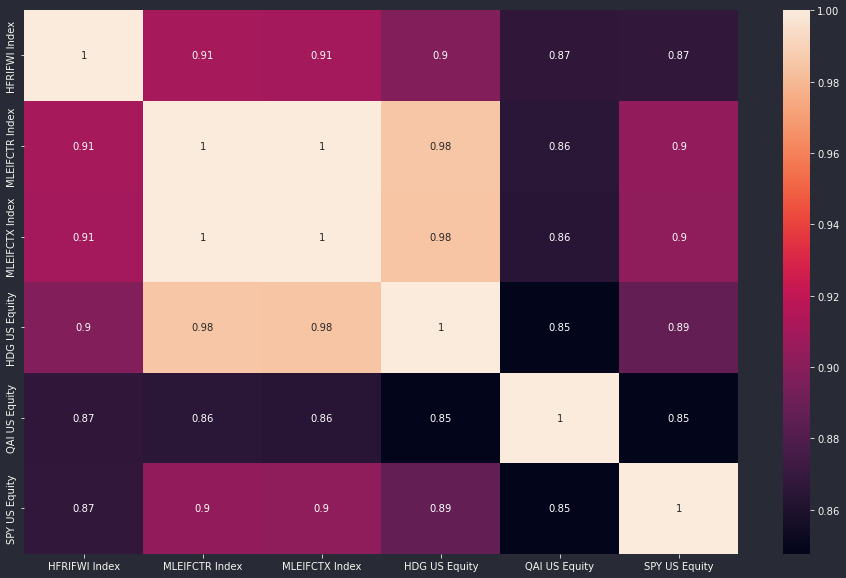

In [6]:
merged = pd.concat([hf, mer["SPY US Equity"]], axis=1)
mcor = merged.corr()

mcor_ranked = mcor.unstack().sort_values(ascending=False)[mcor.shape[0]:]

sns.heatmap(mcor, annot=True)
plt.show()

# 6. Replicate HFRI with the six factors listed on the “merrill factors” tab. Include a constant, and run the unrestricted regression,

$$\begin{aligned}
r_t^{hfri} &= \alpha^{merr} + x^{merr}_t \beta^{merr} + \epsilon^{merr}_t \\
\hat{r}_t^{hfri} &= \hat{\alpha}^{merr} + x^{merr}_t \hat{\beta}^{merr}
\end{aligned}$$

Note that the second equation is just our notation for the fitted replication.

(a) Report the intercept and betas.

(b) Are the betas realistic position sizes, or do they require huge long-short positions?

(c) Report the R-squared.

(d) Report the volatility of $\epsilon^{merr}$, (the tracking error.)

In [7]:
unres = sm.OLS(hf["HFRIFWI Index"], sm.add_constant(mer)).fit()
print("(a) intercept and betas:")
print(unres.params)
print(f"(c) R^2 = {unres.rsquared:.4f} adj-R^2 = {unres.rsquared_adj:.4f}")
print(f"(d) Tracking error: {unres.resid.std() * np.sqrt(12):.4f}")

(a) intercept and betas:
const            0.001147
SPY US Equity    0.072022
USGG3M Index    -0.400591
EEM US Equity    0.072159
EFA US Equity    0.106318
EUO US Equity    0.022431
IWM US Equity    0.130892
dtype: float64
(c) R^2 = 0.8557 adj-R^2 = 0.8482
(d) Tracking error: 0.0234


# 7. Let’s examine the replication out-of-sample.

Starting with t = 61 month of the sample, do the following:

• Use the previous 60 months of data to estimate the regression equation, (1). This gives
time-t estimates of the regression parameters, $\tilde{\alpha}^{merr}$ and $\tilde{\beta}^{merr}$

• Use the estimated regression parameters, along with the time-t regressor values, xmerr
t , to calculate the time-t replication value4 that is, with respect to the regression estimate, built “out-of-sample” (OOS).

$$\begin{aligned}
\tilde{r}_t^{hfri} &= \tilde{\alpha}^{merr} + x^{merr}_t \tilde{\beta}^{merr}
\end{aligned}$$

• Step forward to t = 62, and now use t = 2 through t = 61 for the estimation. Re-run the
steps above, and continue this process throughout the data series. Thus, we are running a
rolling, 60-month regression for each point-in-time.

How well does the out-of-sample replication perform with respect to the target?

In [8]:
def step_forward_regression(endo, exog, window, constant=True):
    """
    endo: pd.Series or like (Y values)
    exog: pd.DataFrame or like (X values)
    window: int number of data points used in regression
    constant: bool whether to add a regression coefficient
    """
    if endo.shape[0] != exog.shape[0]:
        raise IndexError(f"Endogenous {endo.shape} and Exogenous {exog.shape} dataframes are of different shape.")
    if constant:
        exog = sm.add_constant(exog)
        
    steps = endo.shape[0] - window
    
    pred = []
    beta = []
    for s in range(steps):
        in_endo = endo.iloc[s:window+s]
        ou_endo = endo.iloc[window+s:]
        in_exog = exog.iloc[s:window+s,:]
        ou_exog = exog.iloc[window+s:, :]
        
        reg_step = sm.OLS(in_endo, in_exog).fit()
        p = reg_step.predict(ou_exog.values[0])
        pred.append(p[0])
        beta.append(reg_step.params.values)
    
    actual = endo.iloc[window:]
    pred = pd.Series(pred, index=actual.index)
    beta = pd.DataFrame(beta, index=actual.index, columns=exog.columns)
    return pred, actual, beta

pred, actual, beta = step_forward_regression(hf["HFRIFWI Index"], mer, window=60)

pd.concat([pred, actual], axis=1).rename(columns={0: "Predicted", 'HFRIFWI Index': "Actual"})

,Predicted,Actual
date,,
2016-08-31,0.004955,0.004274
2016-09-30,0.004992,0.006468
2016-10-31,-0.004454,-0.005947
2016-11-30,0.011669,0.007660
2016-12-31,0.007638,0.010063
...,...,...
2021-05-31,0.008153,0.013401
2021-06-30,0.007416,0.005424
2021-07-31,-0.006910,-0.009095


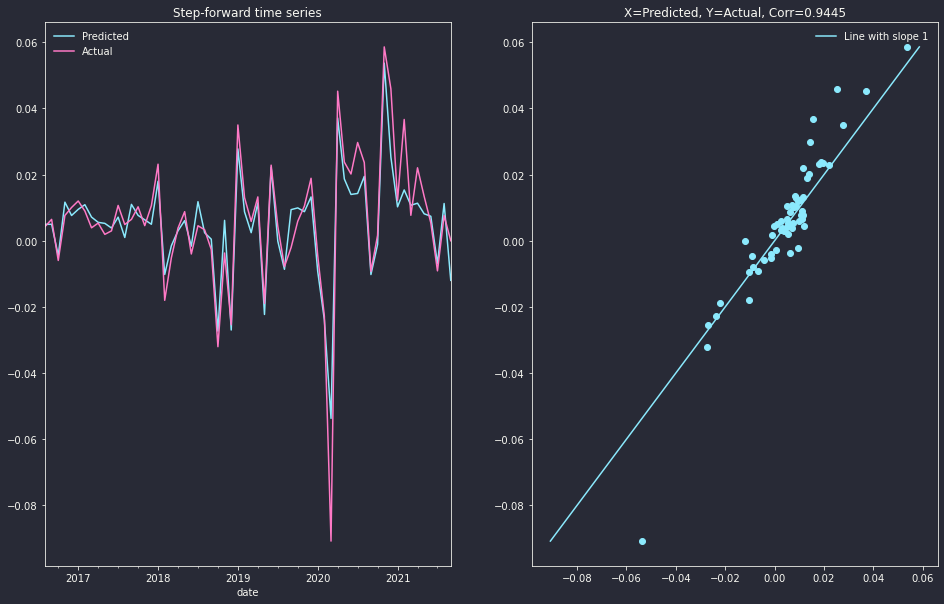

In [9]:
fig, axs = plt.subplots(1,2)

pred.plot(label="Predicted", ax=axs[0])
actual.plot(label="Actual", ax=axs[0])
axs[0].legend()
axs[0].set_title("Step-forward time series")

axs[1].scatter(pred, actual)
reg_cor = np.corrcoef(pred,actual)[0,1]
axs[1].set_title(f"X=Predicted, Y=Actual, Corr={reg_cor:.4f}")
line = [min(min(pred), min(actual)), max(max(pred), max(actual))]
axs[1].plot(line, line, label="Line with slope 1")
axs[1].legend()

plt.show()

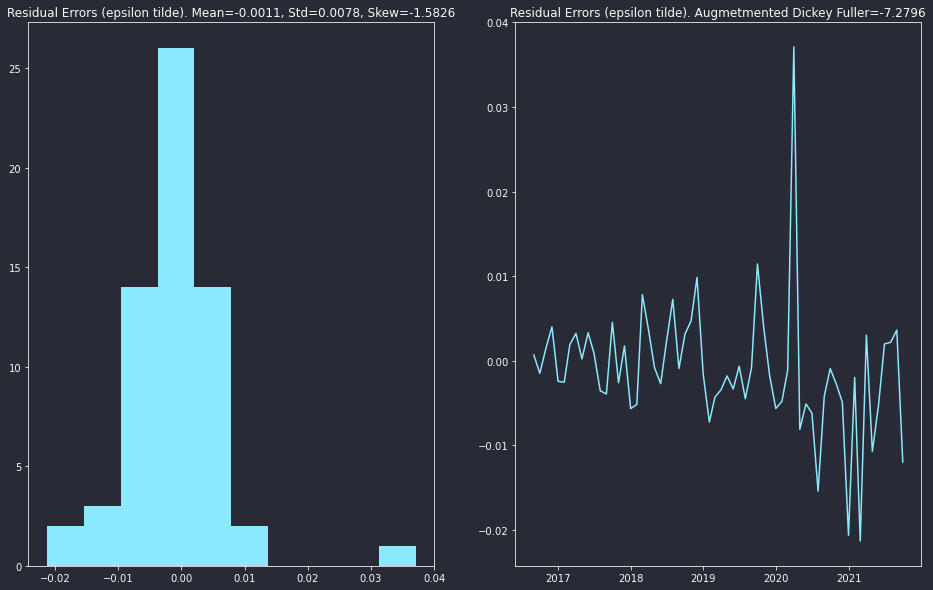

In [10]:
resid = pred - actual

fig, axs = plt.subplots(1,2)

axs[0].hist(resid)
axs[0].set_title(f"Residual Errors (epsilon tilde). Mean={resid.mean():.4f}, Std={resid.std():.4f}, Skew={resid.skew()-3:.4f}")
axs[1].plot(resid)
axs[1].set_title(f"Residual Errors (epsilon tilde). Augmetmented Dickey Fuller={tsa.stattools.adfuller(resid)[0]:.4f}")

plt.show()

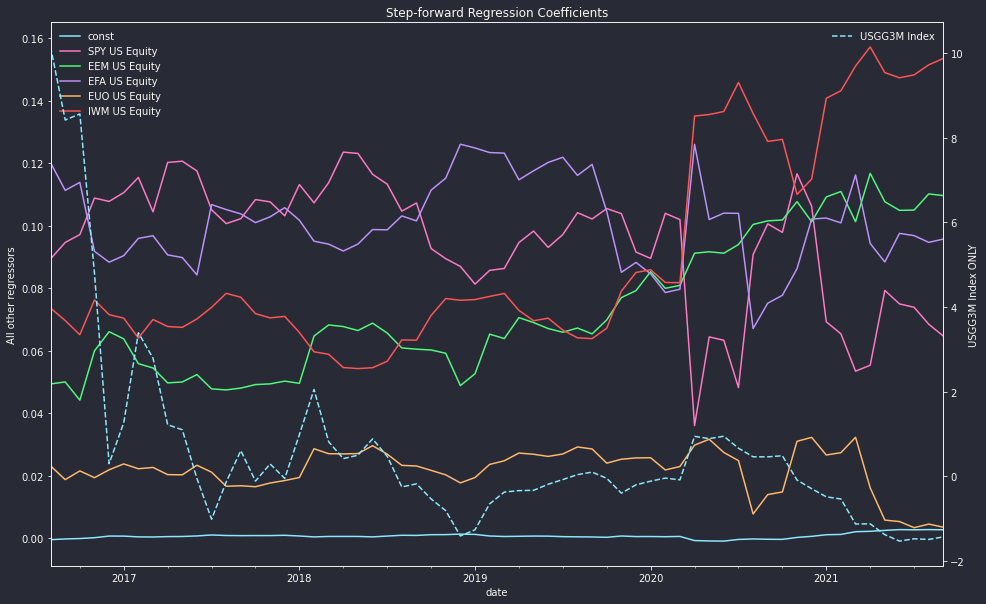

In [11]:
fig, ax0 = plt.subplots()
ax1 = ax0.twinx()

left = beta.drop("USGG3M Index", axis=1)
right = beta["USGG3M Index"]

left.plot(ax=ax0)
ax0.set_ylabel("All other regressors")
right.plot(ax=ax1, linestyle="dashed")
ax1.set_ylabel("USGG3M Index ONLY")

plt.title("Step-forward Regression Coefficients")
ax1.legend()
plt.show()

# 8. We estimated the replications using an intercept. Try the full-sample estimation, but this time without an intercept.

$$\begin{aligned}
r_t^{hfri} &= \alpha^{merr} + x^{merr}_t \beta^{merr} + \epsilon^{merr}_t \\
\check{r}_t^{hfri} &= \check{\alpha}^{merr} + x^{merr}_t \check{\beta}^{merr}
\end{aligned}$$

Report

(a) the regression beta. How does it compare to the estimated beta with an intercept, $\check{\beta}^{hfri}$?

(b) the mean of the fitted value, $\check{r}_t^{hfri}$. How does it compare to the mean of the HFRI?

(c) the correlations of the fitted values, $\check{r}_t^{hfri}$ to the HFRI. How does the correlation compare to that of the fitted values with an intercept, $\check{r}_t^{hfri}$

Do you think Merrill and ProShares fit their replicators with an intercept or not?

In [12]:
nores = sm.OLS(hf["HFRIFWI Index"], mer).fit()
print("(a) intercept and betas:")
print(nores.params)

rcheck = nores.predict(mer) # no intercept
print(f"(b) mean of fitted rcheck={rcheck.mean():.4f}")
hf_mu = hf["HFRIFWI Index"].mean()
print(f"    mean of HFRI         ={hf_mu:.4f}")

rhat = unres.predict(sm.add_constant(mer)) # intercept
cor_rcheck_hfri = np.corrcoef(rcheck, hf["HFRIFWI Index"])[0,1]
cor_rhat_hfri = np.corrcoef(rhat, hf["HFRIFWI Index"])[0,1]
print(f"(c) Correlation(no intercept, HFRI)={cor_rcheck_hfri:.4f}")
print(f"    Correlation(w/ intercept, HFRI)={cor_rhat_hfri:.4f}")

(a) intercept and betas:
SPY US Equity    0.087505
USGG3M Index     0.334503
EEM US Equity    0.069936
EFA US Equity    0.101524
EUO US Equity    0.023479
IWM US Equity    0.128999
dtype: float64
(b) mean of fitted rcheck=0.0036
    mean of HFRI         =0.0042
(c) Correlation(no intercept, HFRI)=0.9245
    Correlation(w/ intercept, HFRI)=0.9250
